In [15]:
import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

%matplotlib inline

In [2]:
def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out


def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim="time")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


Text(0.5, 0, 'Year')

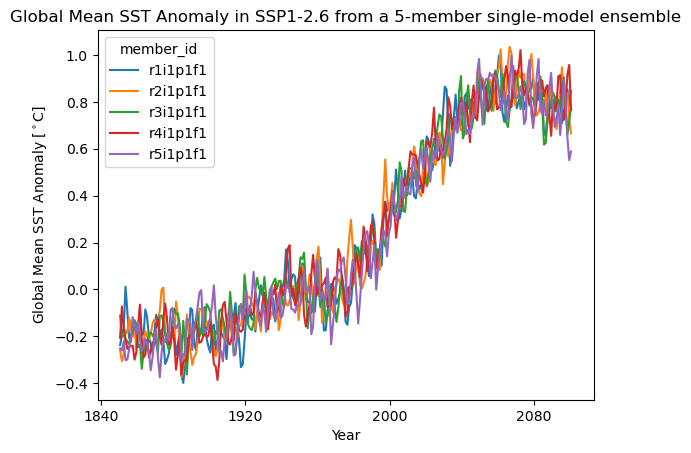

In [16]:
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

cat_ensemble = col.search(
    source_id="MPI-ESM1-2-LR",
    variable_id="tos",
    table_id="Omon",
    # select the 5 ensemble members described above
    member_id=["r1i1p1f1", "r2i1p1f1", "r3i1p1f1", "r4i1p1f1", "r5i1p1f1"],
    grid_label="gn",
    experiment_id=["historical", "ssp126", "ssp585"],
    require_all_on=["source_id", "member_id"],
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the
# actual tutorial, so this would be a lot cleaner
cat_ensemble.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_ensemble = cat_ensemble.to_datatree(**kwargs)

cat_area = col.search(
    source_id=["MPI-ESM1-2-LR"],
    # for the coding exercise, ellipses will go after the equals on this line
    variable_id="areacello",
    member_id="r1i1p1f1",
    table_id="Ofx",  # for the coding exercise, ellipses will go after the equals on this line
    grid_label="gn",
    experiment_id=[
        "historical"
    ],  # for the coding exercise, ellipses will go after the equals on this line
    require_all_on=["source_id"],
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the
# actual tutorial, so this would be a lot cleaner
cat_area.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_area = cat_area.to_datatree(**kwargs)

# add the area (we can reuse the area from before, since for a given model the horizontal are does not vary between members)
dt_ensemble_with_area = DataTree()
for model, subtree in dt_ensemble.items():
    metric = dt_area["MPI-ESM1-2-LR"]["historical"].ds["areacello"].squeeze()
    dt_ensemble_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)

# global average
# average every dataset in the tree globally
dt_ensemble_gm = dt_ensemble_with_area.map_over_subtree(global_mean)

# calculate anomaly
dt_ensemble_gm_anomaly = datatree_anomaly(dt_ensemble_gm)


def plot_historical_ssp126_ensemble_combined(dt, ax):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].ds.coarsen(time=12).mean().tos)

        # concatenate the historical and ssp126 timeseries for each ensemble member
        da_combined = xr.concat(datasets, dim="time")
        # plot annual averages
        da_combined.plot(hue="member_id", ax=ax)


fig, ax = plt.subplots()
plot_historical_ssp126_ensemble_combined(dt_ensemble_gm_anomaly, ax)

ax.set_title(
    "Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble"
)
ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")
ax.set_xlabel("Year")

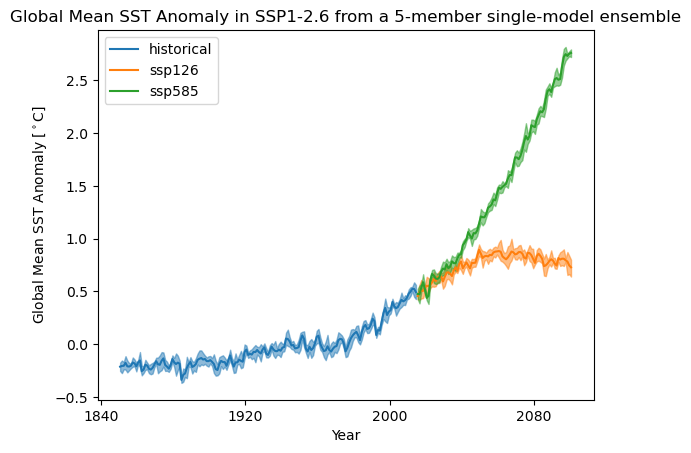

In [17]:
fig, ax = plt.subplots()

for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    da = (
        dt_ensemble_gm_anomaly["MPI-ESM1-2-LR"][experiment]
        .ds.tos.coarsen(time=12)
        .mean()
        .load()
    )
    # calculate the mean across ensemble members
    da.mean("member_id").plot(color=color, label=experiment, ax=ax)

    # shading representing spread between members
    x = da.time.data
    # diagnose the lower range of the likely bounds
    da_lower = da.squeeze().quantile(0.17, dim="member_id")
    # diagnose the upper range of the likely bounds
    da_upper = da.squeeze().quantile(0.83, dim="member_id")
    ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)

ax.set_title(
    "Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble"
)
ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()
plt.show()